<a id="top"></a>
# Getting Started with the Iguazio Data Science Platform

## Overview <a id="gs-overview"></a>



1. [Create and configure a new project](#gs-step-project-create-n-config)
2. [Ingest a data set](#gs-step-ingest-data)
3. [Explore the data](#gs-step-explore-data)
4. [Run model training at scale](#gs-step-run-model-training)
5. [Test your model](#gs-step-test-model)
6. [Create and run a fully automated ML pipeline](#gs-step-create-n-run-ml-pipeline)



## Step 1: Create and Configure a New Project <a id="gs-step-project-create-n-config"></a>

### Create a New Project <a id="gs-create-project"></a>

In [1]:
from os import path, getenv
from mlrun import new_project

project_name = '-'.join(filter(None, ['rapid-prototype', getenv('V3IO_USERNAME', None)]))
project_path = path.abspath('conf')
project = new_project(project_name, project_path, init_git=True)

print(f'Project path: {project_path}\nProject name: {project_name}')

Project path: /User/rapid-proto/conf
Project name: rapid-prototype-michaelk


### Configure MLRun <a id="gs-mlrun-config"></a>

In [2]:
from mlrun import run_local, NewTask, mlconf, import_function, mount_v3io

# Target location for storing pipeline artifacts
artifact_path = path.abspath('artifacts')
# MLRun DB path or API service URL
mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'

print(f'Artifacts path: {artifact_path}\nMLRun DB path: {mlconf.dbpath}')

Artifacts path: /User/rapid-proto/artifacts
MLRun DB path: http://mlrun-api:8080


#### Import Nuclio <a id="gs-nuclio-import"></a>


In [3]:
import nuclio

In [4]:
# nuclio: start-code

In [5]:
%nuclio config spec.build.baseImage = "mlrun/ml-models"
%nuclio config kind = "job"
%nuclio cmd -c pip install v3io-frames==0.6.18

%nuclio: setting spec.build.baseImage to 'mlrun/ml-models'
%nuclio: setting kind to 'job'


## Step 2: Take a Snapshot Data Set of the KV feature table <a id="gs-step-ingest-data"></a>


### Initialization <a id="gs-step-ingest-data-init"></a>


In [6]:
# nuclio: ignore
# Set the source-data URL
container = 'users'
table_path = path.join(getenv('V3IO_USERNAME'),'examples/rapid-prototype/feature-table')
columns = ['label', 'socioeconomic_idx', 
           'purchase_sum', 'purchase_mean', 'purchase_count', 'purchase_var', 
           'bet_sum', 'bet_mean', 'bet_count' ,'bet_var',
           'win_sum', 'win_mean', 'win_count' ,'win_var']
format = 'csv'

### Define a Data-Snapshot Function <a id="gs-step-ingest-data-define-function"></a>


In [7]:
from os import path
import pandas as pd
import v3io_frames as v3f


# Ingest a data set into the platform
def snapshot_data(context, container, table_path, columns, format='csv'):
    
    client = v3f.Client("framesd:8081", container=container)
    client.execute(backend="kv", table=table_path, command="infer")
    df = client.read('kv', table_path, columns=columns)
    
    target_path = path.join(context.artifact_path, 'data')
    # Optionally print data to your logger
    context.logger.info('Saving snapshot data set to {} ...'.format(target_path))
    
    # Store the data set in your artifacts database
    context.log_dataset('snapshot_dataset', df=df, format=format,
                        index=False, artifact_path=target_path)

In [8]:
# nuclio: end-code

<a id='gs-run-ingest-func-local'></a>
#### Run the Function Locally in Jupyter Notebook

In [9]:
# Run the data-ingestion function locally in Jupyter Notebook
snapshot_data_run = run_local(name='snapshot_data',
                         handler=snapshot_data,
                         params={'container': container, 'table_path': table_path, 
                                 'columns':columns, 'format': format},
                         project=project_name, artifact_path=artifact_path)

> 2020-07-30 13:17:14,052 [info] starting run snapshot_data uid=483c924b3e6541b88ea5777cf1674a8a  -> http://mlrun-api:8080
> 2020-07-30 13:17:14,277 [info] Saving snapshot data set to /User/rapid-proto/artifacts/data ...


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
rapid-prototype-michaelk,...f1674a8a,0,Jul 30 13:17:14,completed,snapshot_data,v3io_user=michaelkkind=handlerowner=michaelkhost=jupyter-mk-7c7fc6cc67-fkkvj,,"container=userstable_path=michaelk/examples/rapid-prototype/feature-tablecolumns=['label', 'socioeconomic_idx', 'purchase_sum', 'purchase_mean', 'purchase_count', 'purchase_var', 'bet_sum', 'bet_mean', 'bet_count', 'bet_var', 'win_sum', 'win_mean', 'win_count', 'win_var']format=csv",,snapshot_dataset


to track results use .show() or .logs() or in CLI: 
!mlrun get run 483c924b3e6541b88ea5777cf1674a8a --project rapid-prototype-michaelk , !mlrun logs 483c924b3e6541b88ea5777cf1674a8a --project rapid-prototype-michaelk
> 2020-07-30 13:17:14,473 [info] run executed, status=completed


#### Run the Function on a Cluster <a id="gs-run-ingest-func-cluster"></a>


In [10]:
from mlrun import code_to_function

# Convert the local snapshot_data function into a gen_func project function
gen_func = code_to_function(name='snapshot-data')
project.set_function(gen_func)
snapshot_data_func = project.func('snapshot-data').apply(mount_v3io())

In [11]:
#Build image
snapshot_data_func.deploy()

> 2020-07-30 13:17:19,346 [info] starting remote build, image: .mlrun/func-rapid-prototype-michaelk-snapshot-data-latest
INFO[0000] Resolved base name mlrun/ml-models:0.5.1-rc1 to mlrun/ml-models:0.5.1-rc1 
INFO[0000] Resolved base name mlrun/ml-models:0.5.1-rc1 to mlrun/ml-models:0.5.1-rc1 
INFO[0000] Retrieving image manifest mlrun/ml-models:0.5.1-rc1 
INFO[0002] Retrieving image manifest mlrun/ml-models:0.5.1-rc1 
INFO[0004] Built cross stage deps: map[]                
INFO[0004] Retrieving image manifest mlrun/ml-models:0.5.1-rc1 
INFO[0005] Retrieving image manifest mlrun/ml-models:0.5.1-rc1 
INFO[0006] Unpacking rootfs as cmd RUN pip install v3io-frames==0.6.18 requires it. 
INFO[0153] Taking snapshot of full filesystem...        
INFO[0159] Resolving paths                              
INFO[0182] RUN pip install v3io-frames==0.6.18          
INFO[0182] cmd: /bin/sh                                 
INFO[0182] args: [-c pip install v3io-frames==0.6.18]   
INFO[0189] Taking snapsh

True

##### Run the Function on the Cluster <a id="gs-run-ingest-func-on-the-cluster-run-function"></a>


In [12]:

snapshot_data_run = snapshot_data_func.run(name='snapshot_data',
                                 handler='snapshot_data',
                                 params={'container': container, 'table_path': table_path, 
                                         'columns':columns, 'format': format},
                                 artifact_path=artifact_path)

> 2020-07-30 13:27:46,452 [info] starting run snapshot_data uid=4d1887ac85a64adeb6ff8687aeac4d2a  -> http://mlrun-api:8080
> 2020-07-30 13:27:46,569 [info] Job is running in the background, pod: snapshot-data-p2vrs
> 2020-07-30 13:27:52,387 [info] Saving snapshot data set to /User/rapid-proto/artifacts/data ...
> 2020-07-30 13:27:52,526 [info] run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
rapid-prototype-michaelk,...aeac4d2a,0,Jul 30 13:27:52,completed,snapshot_data,v3io_user=michaelkkind=jobowner=michaelkhost=snapshot-data-p2vrs,,"container=userstable_path=michaelk/examples/rapid-prototype/feature-tablecolumns=['label', 'socioeconomic_idx', 'purchase_sum', 'purchase_mean', 'purchase_count', 'purchase_var', 'bet_sum', 'bet_mean', 'bet_count', 'bet_var', 'win_sum', 'win_mean', 'win_count', 'win_var']format=csv",,snapshot_dataset


to track results use .show() or .logs() or in CLI: 
!mlrun get run 4d1887ac85a64adeb6ff8687aeac4d2a --project rapid-prototype-michaelk , !mlrun logs 4d1887ac85a64adeb6ff8687aeac4d2a --project rapid-prototype-michaelk
> 2020-07-30 13:27:55,743 [info] run executed, status=completed


## Step 3: Explore the Data <a id="gs-step-explore-data"></a>


### Explore the Data with Pandas DataFrames <a id="gs-explore-data-w-pandas-df"></a>


Run the following code to use pandas DataFrames to read your data set, extract some basic statistics, and display them.

In [13]:
# Read your data set
from mlrun.run import get_dataitem
df = get_dataitem(snapshot_data_run.outputs['snapshot_dataset']).as_df()

In [14]:
# Display a portion of the read data
df.head()

,label,socioeconomic_idx,purchase_sum,purchase_mean,purchase_count,purchase_var,bet_sum,bet_mean,bet_count,bet_var,win_sum,win_mean,win_count,win_var
0,1,3,5229,49,104,121,8422,10,876,5,1710.0,190.0,9.0,2166.0
1,0,6,807,50,16,141,1924,10,204,5,2804.0,201.0,14.0,2417.0
2,0,6,767,53,14,142,1087,8,115,7,1532.0,218.0,7.0,2358.0
3,1,2,4906,50,95,139,7587,10,797,5,1884.0,237.0,8.0,2824.0
4,0,1,677,46,15,132,832,9,85,5,1062.0,212.0,5.0,1818.0


In [15]:
# Calculate and display the number of data-set items
print(f'Total number of rows: {len(df)}')

Total number of rows: 1999


In [16]:
# Display statistics grouped by label
df.groupby(['label']).describe()

socioeconomic_idx                                               \
                  count      mean       std  min  25%  50%  75%  max   
label                                                                  
0                 600.0  5.026667  1.829809  1.0  4.0  5.0  6.0  7.0   
1                1399.0  2.998570  1.846777  1.0  2.0  3.0  4.0  7.0   

      purchase_sum               ... win_count       win_var               \
             count         mean  ...       75%   max   count         mean   
label                            ...                                        
0            600.0  1583.111667  ...      24.0  57.0   586.0  2074.360068   
1           1399.0  4311.554682  ...      10.5  22.0  1399.0  2176.924946   

                                                          
               std  min     25%     50%     75%      max  
label                                                     
0      1039.848529  0.0  1634.5  2094.0  2505.0  10658.0  
1       960.046169  0.0  1611.0  2155.0  2689.5  12800.0  

[2 rows x 104 columns]

### Explore the Data with an MLRun Marketplace Function <a id="gs-explore-data-w-mlrun-func"></a>


#### Add an Exploration Function <a id="gs-explore-data-w-mlrun-func-add-func"></a>


In [17]:
project.set_function('hub://describe', 'describe')
describe = project.func('describe').apply(mount_v3io())

#### Run the Exploration Function <a id="gs-explore-data-w-mlrun-func-run-func"></a>


In [18]:
describe_run = describe.run(params={'label_column': 'label'},
                            inputs={"table":
                                    snapshot_data_run.outputs['snapshot_dataset']},
                            artifact_path=artifact_path)

> 2020-07-30 13:28:40,344 [info] starting run describe-summarize uid=8b965a85f1ec4b1bba456d90581e2e61  -> http://mlrun-api:8080
> 2020-07-30 13:28:40,469 [info] Job is running in the background, pod: describe-summarize-vqz7k
> 2020-07-30 13:29:29,462 [info] run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
rapid-prototype-michaelk,...581e2e61,0,Jul 30 13:28:46,completed,describe-summarize,v3io_user=michaelkkind=jobowner=michaelkhost=describe-summarize-vqz7k,table,label_column=label,,histogramsviolinimbalanceimbalance-weights-veccorrelation-matrixcorrelation


to track results use .show() or .logs() or in CLI: 
!mlrun get run 8b965a85f1ec4b1bba456d90581e2e61 --project rapid-prototype-michaelk , !mlrun logs 8b965a85f1ec4b1bba456d90581e2e61 --project rapid-prototype-michaelk
> 2020-07-30 13:29:32,890 [info] run executed, status=completed


#### Review the Run Output <a id="gs-explore-data-w-mlrun-func-run-output-review"></a>



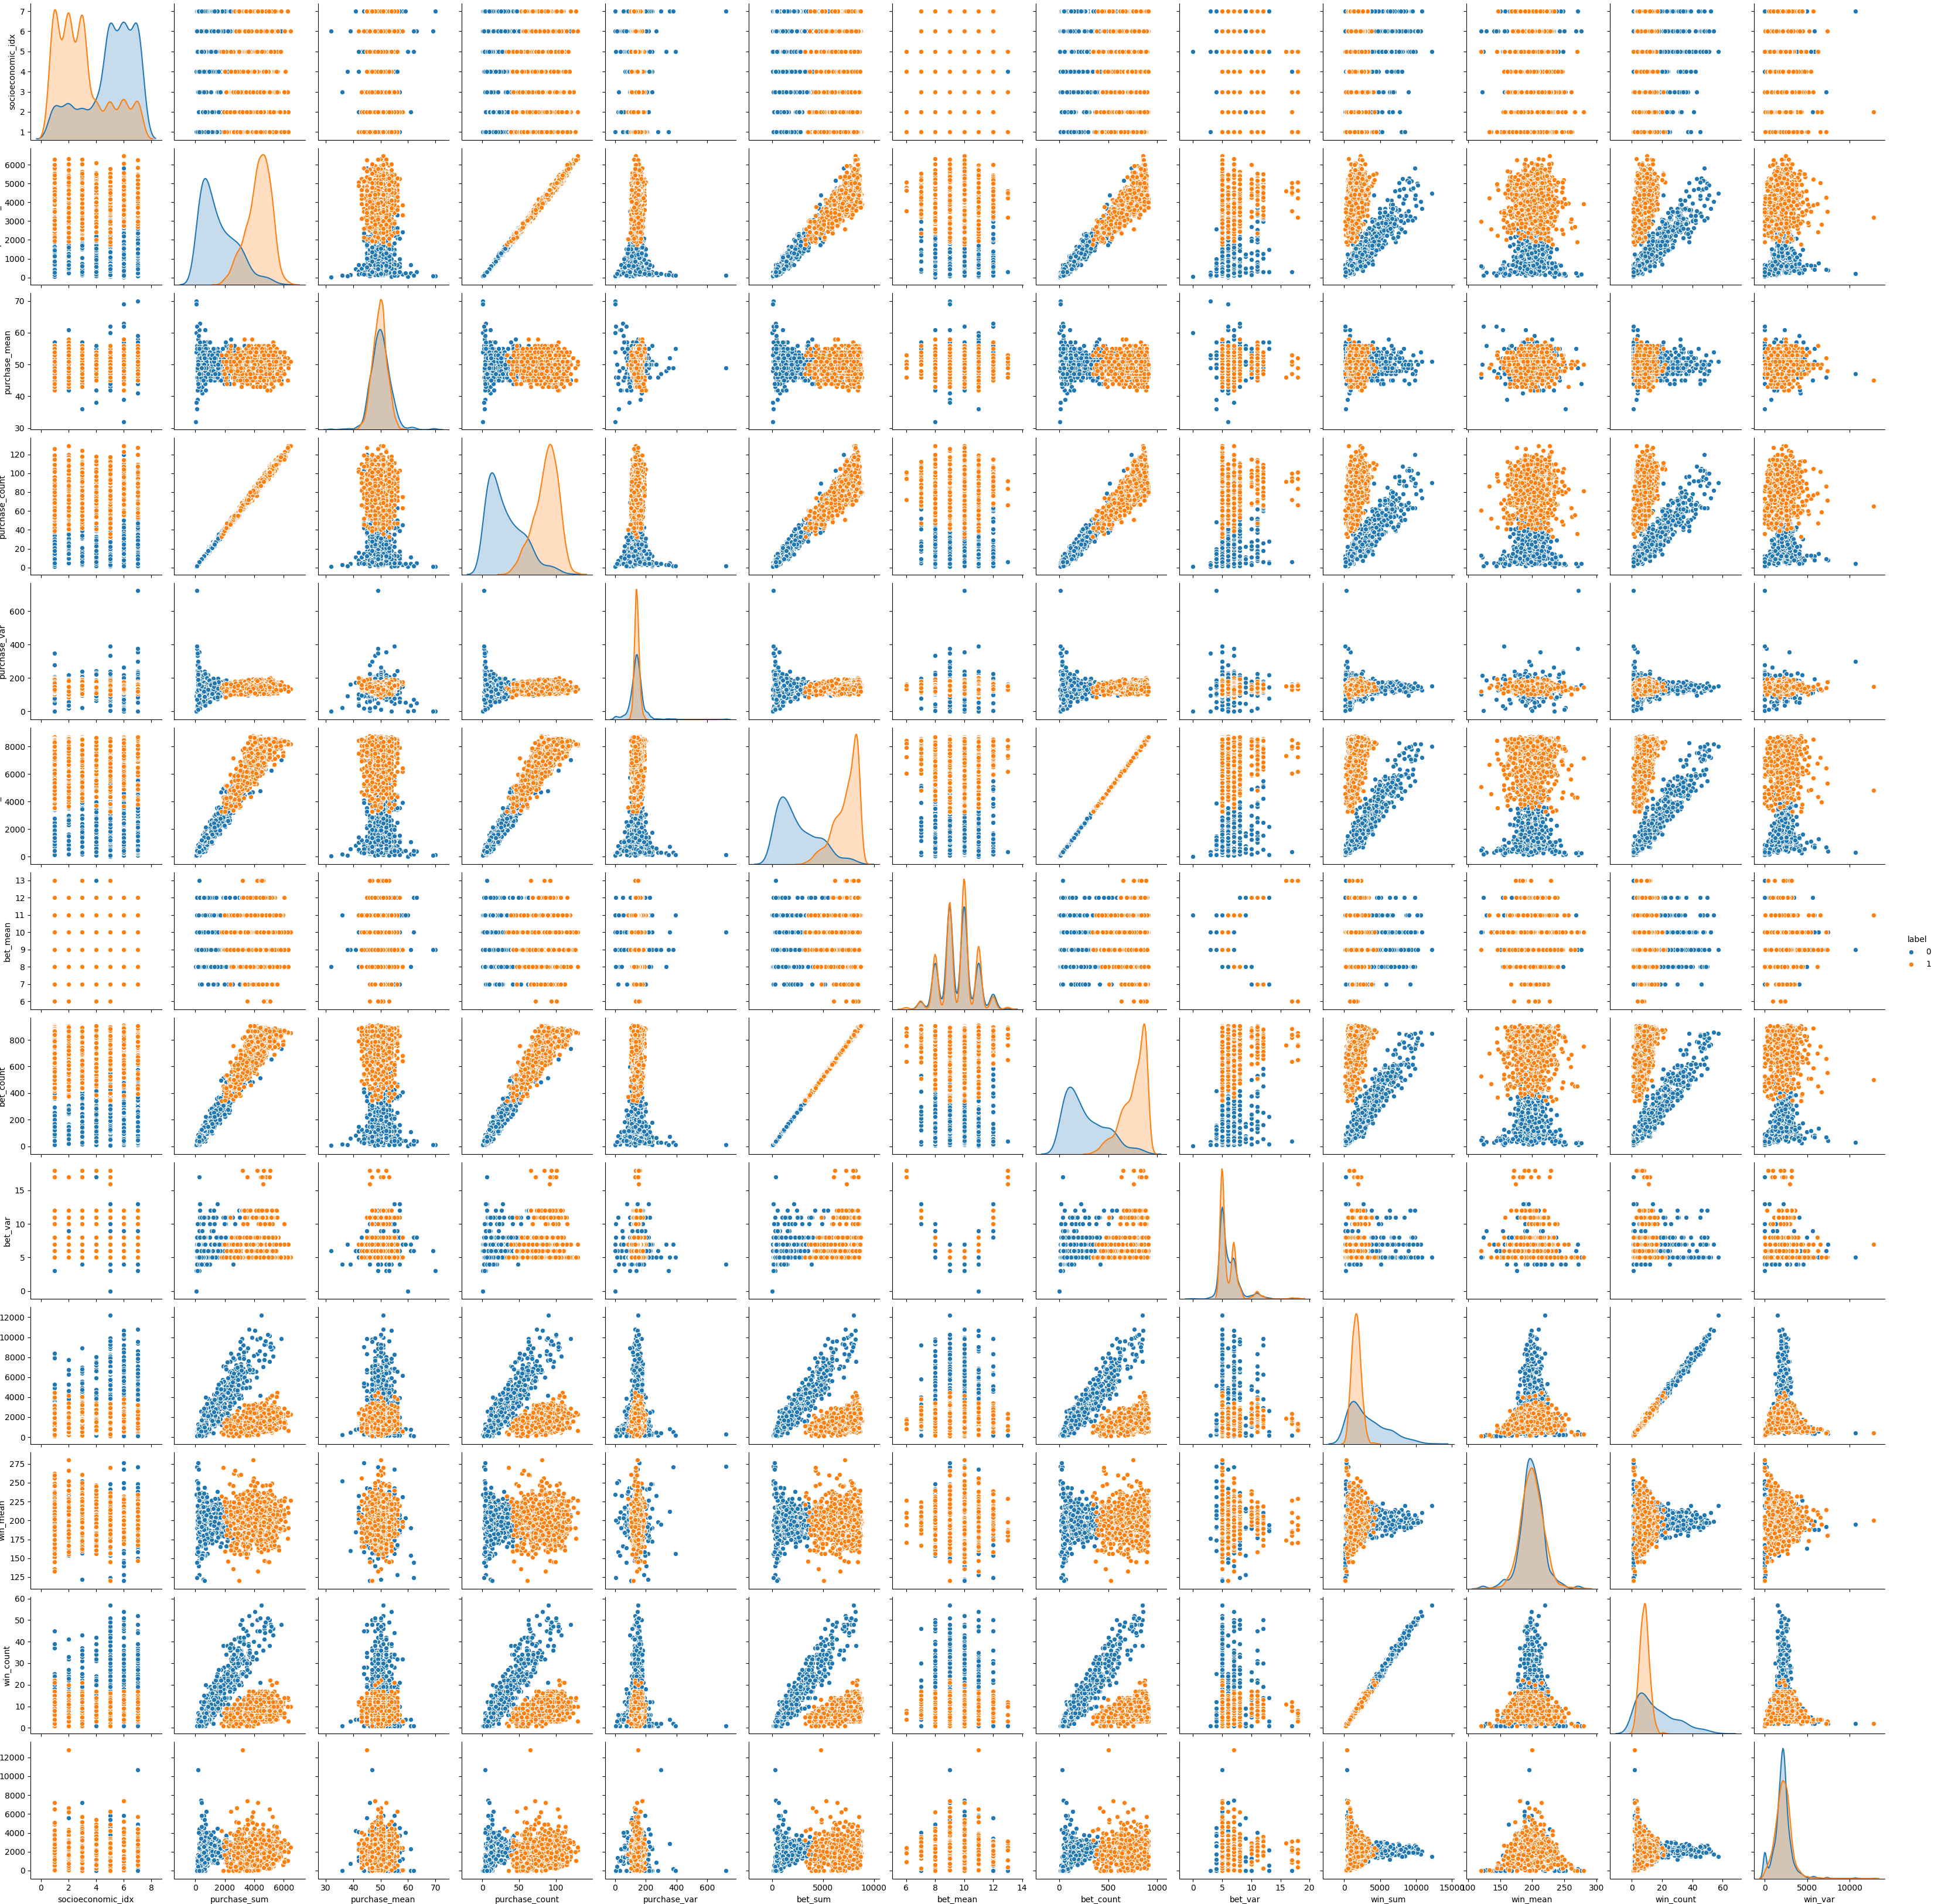

In [19]:
from IPython.display import display, HTML

# Display the `histograms` artifact
display(HTML('<h3>Histograms</h3>'), HTML(describe_run.outputs['histograms']))


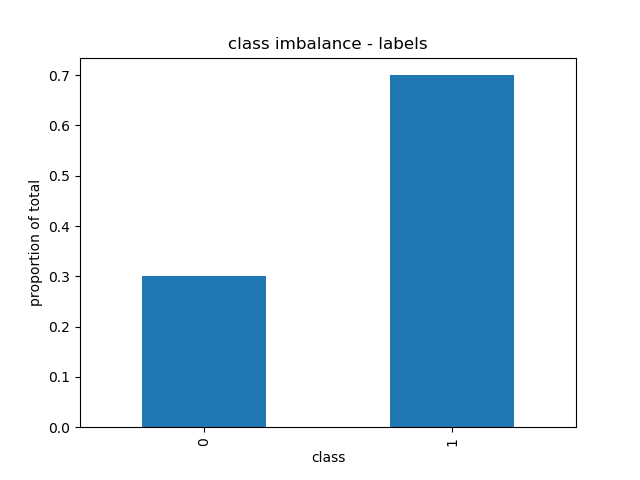

In [20]:
# Display the `imbalance` artifact
display(HTML('<h3>Imbalance<h3>'),
        HTML(filename=describe_run.outputs['imbalance']))


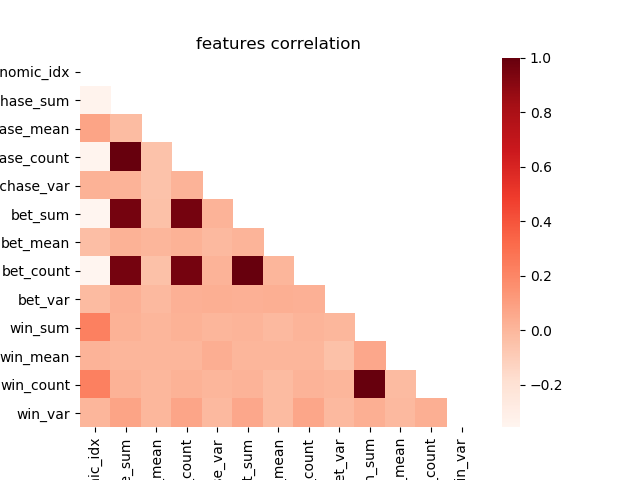

In [21]:
# Display the `correlation` artifact
display(HTML('<h3>Correlation Matrix<h3>'),
        HTML(filename=describe_run.outputs['correlation']))

## Step 4: Run Model Training at Scale <a id="gs-step-run-model-training"></a>


#### Add a Training Function <a id="gs-train-model-add-func"></a>


In [22]:
project.set_function('hub://sklearn_classifier', 'train')
train = project.func('train').apply(mount_v3io())

#### Run a Model-Training Task <a id="gs-train-model-run-task"></a>


In [23]:
# Configure the models to train
models = ["sklearn.ensemble.RandomForestClassifier", 
          "sklearn.linear_model.LogisticRegression",
          "sklearn.ensemble.AdaBoostClassifier"]

In [24]:
# Create a training task
train_task = NewTask(name="train",
                     params={"sample": -1,
                             "label_column": "label",
                             "test_size": 0.10},
                     inputs={"dataset": snapshot_data_run.outputs['snapshot_dataset']})

# Run the training task
train_run = train.run(train_task.with_hyper_params({'model_pkg_class': models},
                                                   selector='max.accuracy'),
                      artifact_path=artifact_path)

> 2020-07-30 13:30:07,163 [info] starting run train uid=a311407169594385b62fcbd933b60621  -> http://mlrun-api:8080
> 2020-07-30 13:30:07,298 [info] Job is running in the background, pod: train-dlwt8
> 2020-07-30 13:30:16,640 [info] best iteration=3, used criteria max.accuracy
> 2020-07-30 13:30:16,896 [info] run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...33b60621,0,Jul 30 13:30:12,completed,train,v3io_user=michaelkkind=jobowner=michaelk,dataset,sample=-1label_column=labeltest_size=0.1,best_iteration=3accuracy=1.0test-error=0.0rocauc=1.0brier_score=0.029259539828715122f1-score=1.0precision_score=1.0recall_score=1.0,test_setprobability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binarymodeliteration_results


to track results use .show() or .logs() or in CLI: 
!mlrun get run a311407169594385b62fcbd933b60621 --project default , !mlrun logs a311407169594385b62fcbd933b60621 --project default
> 2020-07-30 13:30:26,526 [info] run executed, status=completed


### Review the Run Output <a id="gs-train-model-run-output-review"></a>



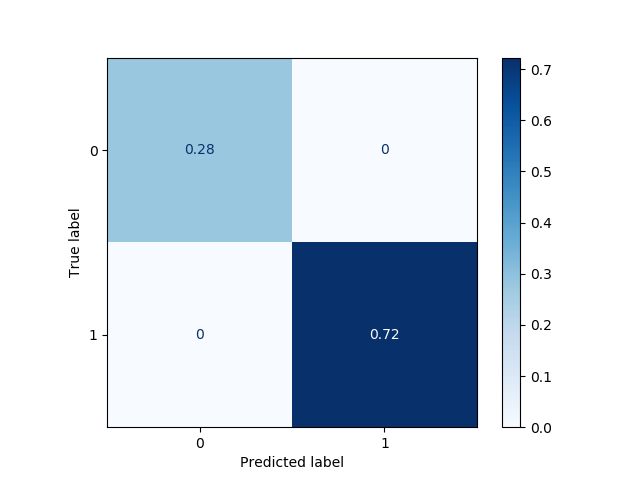


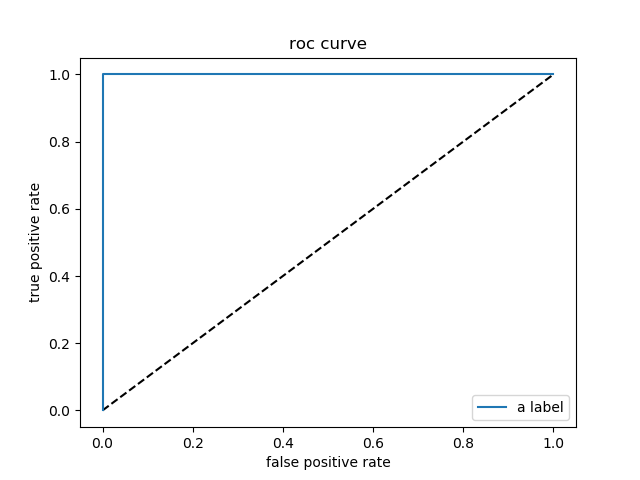

In [25]:
# Display the name of the selected model
display(HTML(f'<b>Best model:</b> '
             f'{models[train_run.outputs["best_iteration"]-1]}'))

# Display the accuracy for the optimal run iteration
display(HTML(f'<b>Accuracy:</b> {train_run.outputs["accuracy"]}'))

# Display HTML output artifacts
display(HTML('<h3>Confusion Matrix:</h3>'),
        HTML(filename=train_run.outputs['confusion-matrix']))
display(HTML('<h3>ROC Curve:</h3>'), HTML(filename=train_run.outputs['roc-binary']))

## Step 5: Test Your Model <a id="gs-step-test-model"></a>


In [26]:
project.set_function('hub://test_classifier', 'test')
test = project.func('test').apply(mount_v3io())

#### Run a Model-Testing Task <a id="gs-test-model-run-task"></a>


In [27]:
test_task = NewTask(name="test",
                    params={"label_column": "label",
                            "plots_dest": path.join("plots", "test")},
                    inputs={"models_path": train_run.outputs['model'],
                            "test_set": train_run.outputs['test_set']}
                    )
test_run = test.run(test_task,
                    artifact_path=artifact_path)

> 2020-07-30 13:32:12,081 [info] starting run test uid=f449459e106d4070b165a2e98ca7d99c  -> http://mlrun-api:8080
> 2020-07-30 13:32:12,221 [info] Job is running in the background, pod: test-vm52f
> 2020-07-30 13:32:19,559 [info] run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...8ca7d99c,0,Jul 30 13:32:18,completed,test,v3io_user=michaelkkind=jobowner=michaelkhost=test-vm52f,models_pathtest_set,label_column=labelplots_dest=plots/test,accuracy=0.9899497487437185test-error=0.010050251256281407rocauc=0.9998707676402171brier_score=0.03689755888770756f1-score=0.993103448275862precision_score=1.0recall_score=0.9863013698630136,probability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binarytest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run f449459e106d4070b165a2e98ca7d99c --project default , !mlrun logs f449459e106d4070b165a2e98ca7d99c --project default
> 2020-07-30 13:32:21,413 [info] run executed, status=completed


### Review the Run Output <a id="gs-test-model-run-output-review"></a>



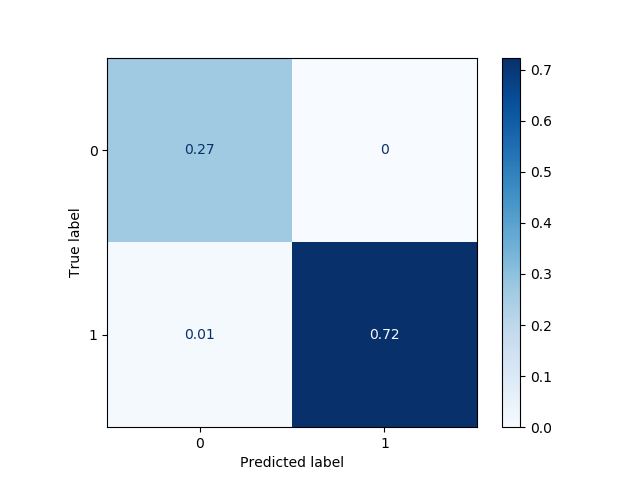


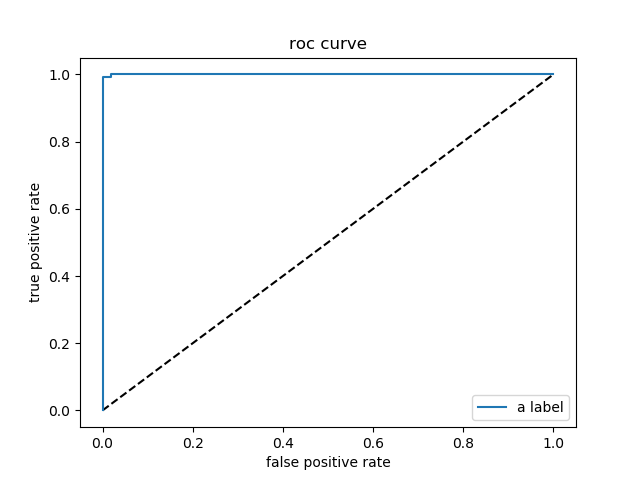

In [28]:
# Display the model accuracy
display(HTML(f'<b>Test Accuracy:</b> {test_run.outputs["accuracy"]}'))

# Display HTML output artifacts
display(HTML("<h3>Confusion matrix:</h3>"),
        HTML(filename=test_run.outputs['confusion-matrix']))
display(HTML("<h3>ROC Curve:</h3>"), HTML(filename=test_run.outputs['roc-binary']))

## Step 6: Save project<a id="gs-step-create-n-run-ml-pipeline"></a>


In [29]:
project.save(path.join(project_path, 'project.yaml'))